# Burst Clustering of Spike Trains

In [1]:
%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import scipy.sparse as sp
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set(style='whitegrid')

In [5]:
arr  = np.loadtxt("SampleLogs/HighConst_Firing.csv", dtype='int', delimiter=",")
timesteps = arr[-1, 0]
neurons = 7520

In [6]:
spikes = sp.coo_matrix((arr[:,2], (arr[:,0]-1, arr[:, 1]-1)), (timesteps, neurons)).tocsc()
isi = np.empty(0)
b2  = np.empty(0)

In [7]:
for i in range(neurons):
    spiketrain = spikes[:, i].indices
    if(len(spiketrain) > 3):
        interval1 = np.diff(spiketrain, 1)
        interval2 = np.diff(spiketrain, 2)
        b = (2 * np.var(interval1) - np.var(interval2)) / (2 * (np.mean(interval1) ** 2))
        isi = np.append(isi, interval1)
        b2 = np.append(b2, b)

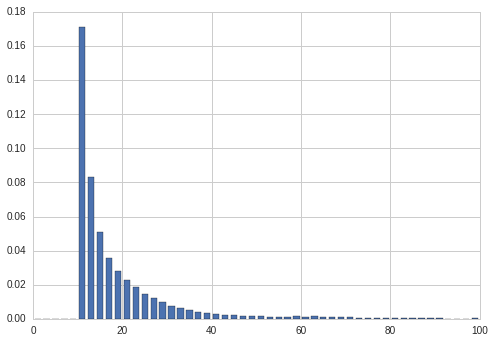

In [8]:
hist, bins = np.histogram(isi, range=(0, 100), bins=50, density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

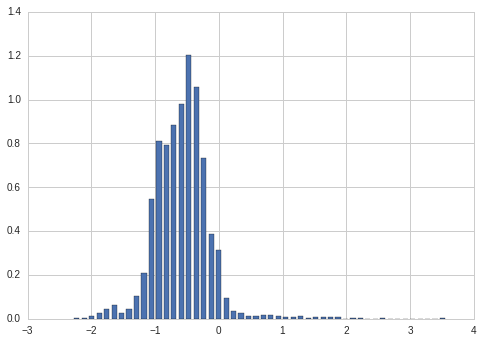

In [9]:
hist, bins = np.histogram(b2, bins=50, density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

In [26]:
threshold = 40
clusters = np.empty(0)
clusters_mean = np.empty(0)
clusters_sd = np.empty(0)
num_spikes = np.empty(0)

In [27]:
for i in range(neurons):
    spiketrain = spikes[:, i].indices
    if(len(spiketrain) > 3):
        interval1 = np.diff(spiketrain, 1)
        clust = np.zeros(1)
        idx = 0
        for j in range(len(interval1)):
            if(interval1[j] <= threshold):
                clust[idx] += 1
            elif(clust[idx] < 3):
                clust[idx] = 0
            else:
                clust = np.append(clust, 0)
                idx += 1
        if(clust[idx] < 3):
            clust = clust[0:idx-1]
        if(len(clust) > 0 and clust[0] > 0):
            clusters      = np.append(clusters, len(clust))
            clusters_mean = np.append(clusters_mean, np.mean(clust))
            clusters_sd   = np.append(clusters_sd, np.std(clust))
            num_spikes    = np.append(num_spikes, len(spiketrain))

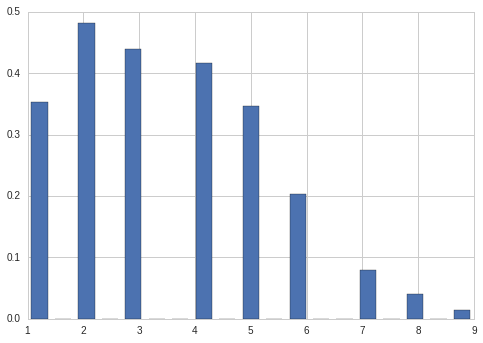

In [28]:
hist, bins = np.histogram(clusters, bins=19, density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

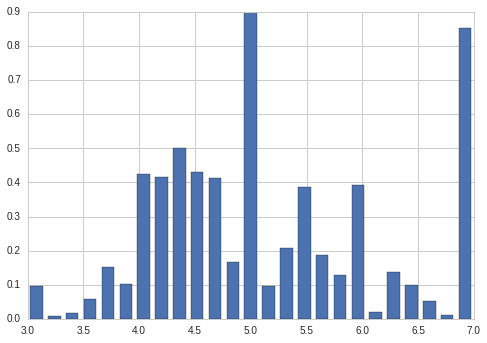

In [29]:
hist, bins = np.histogram(clusters_mean[~np.isnan(clusters_mean)], bins=25, density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

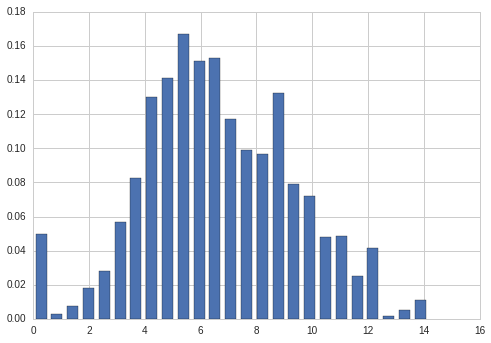

In [103]:
hist, bins = np.histogram(clusters_sd[~np.isnan(clusters_sd)], bins=25, density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()

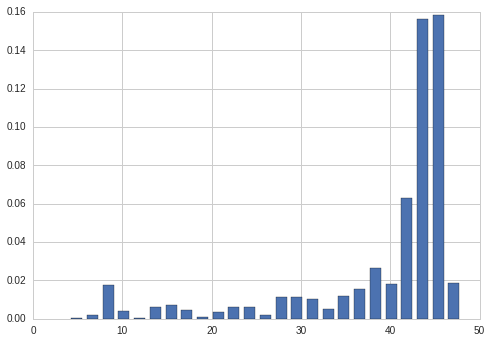

In [104]:
hist, bins = np.histogram(num_spikes, bins=25, density=True)
width = 0.7 * (bins[1] - bins[0])
center = (bins[:-1] + bins[1:]) / 2
plt.bar(center, hist, align='center', width=width)
plt.show()